In [1]:
# Description: This program uses an artificial recurrent neural network call Long Short Term Memory (LSTM)
#              to predict the closing stock price of a corporation (Apple Inc.) using the past 60 days stock price.

In [15]:
# import libraries
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [16]:
# get the stock quote
df = yf.download('AAPL', start='2015-01-01', end='2023-12-31')

# view data
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.435270,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.746883,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.749125,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.082138,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.007431,237458000


In [18]:
# number of rows and columns
df.shape

(2264, 6)

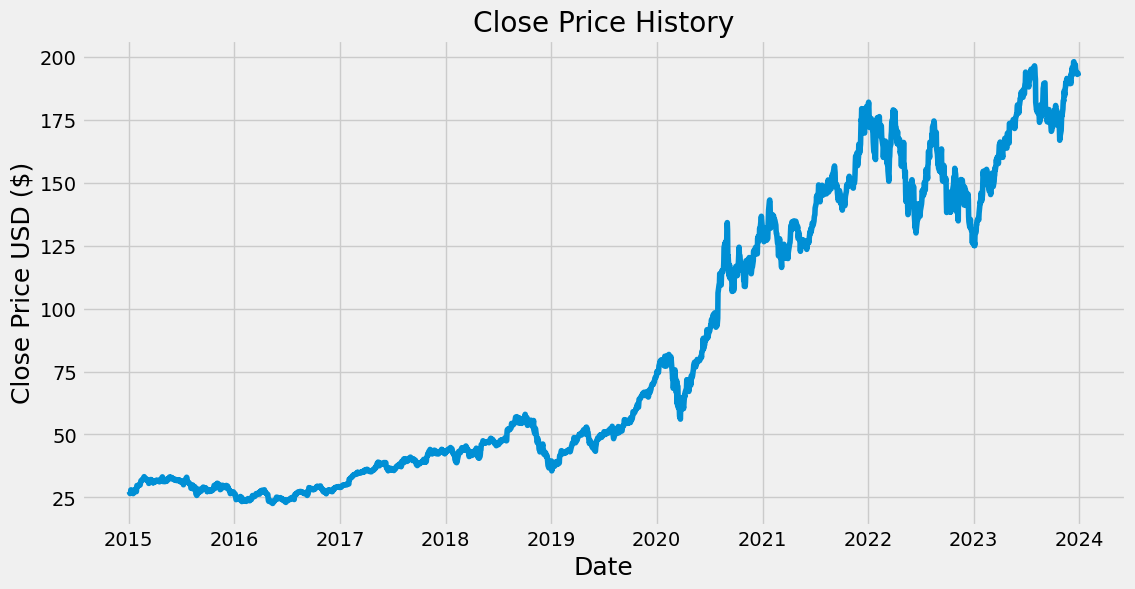

In [23]:
# visualize the closing price
plt.figure(figsize=(12, 6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

## Close price training

In [53]:
# close price data
data = df.filter(['Close'])

dataset = data.values
train_size = math.ceil(len(data)* .8)
train_size

1812

In [54]:
# scale close data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_data = scaler.fit_transform(dataset)

scaled_close_data

array([[0.02704744],
       [0.02266059],
       [0.02267484],
       ...,
       [0.97174188],
       [0.97419172],
       [0.96820965]])

In [55]:
# get close train data
train_data = scaled_close_data[:train_size, :]

# separate features and labels
X_train = []
y_train = []

for i in range(60, len(train_data)):
  X_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i <= 60:
    print(X_train)
    print(y_train)
    print()

[array([0.02704744, 0.02266059, 0.02267484, 0.02479704, 0.03069364,
       0.03086456, 0.02693349, 0.02831506, 0.02771686, 0.02347244,
       0.02229027, 0.02617861, 0.02736078, 0.03142003, 0.03224613,
       0.03241704, 0.02677682, 0.03556474, 0.04067797, 0.0381997 ,
       0.04029341, 0.0403219 , 0.041618  , 0.04215924, 0.0407207 ,
       0.0418459 , 0.04512178, 0.04919527, 0.05144567, 0.05232874,
       0.05339696, 0.05466458, 0.05428002, 0.05577554, 0.06076058,
       0.05957841, 0.05476427, 0.05708589, 0.05429427, 0.05519157,
       0.05557613, 0.0544082 , 0.05137446, 0.05164507, 0.05241419,
       0.04866829, 0.04543512, 0.04858282, 0.04735793, 0.04929497,
       0.05227176, 0.05430851, 0.05292694, 0.05064806, 0.05251389,
       0.05177326, 0.04705882, 0.04828372, 0.04687367, 0.05131748])]
[0.04855434221753735]



In [56]:
# get numpy arrays for split data
X_train, y_train = np.array(X_train), np.array(y_train)

In [57]:
# check train data rows and columns
X_train.shape

(1752, 60)

In [58]:
# reshape data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1752, 60, 1)

## Build model

In [59]:
# build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [60]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [61]:
# train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

1752/1752 [==============================] - 54s 29ms/step - loss: 0.0014


In [62]:
# create test dataset
test_data = scaled_close_data[train_size - 60:, :]

X_test = []
y_test = dataset[train_size:, :]
for i in range(60, len(test_data)):
  X_test.append(test_data[i-60:i, 0])

In [63]:
# get test numpy array
X_test = np.array(X_test)

In [64]:
# reshape data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [65]:
# get predicted values
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

15/15 [==============================] - 1s 14ms/step


In [66]:
# get room mean square error (RMSE)
rmse = np.sqrt(np.mean(y_pred - y_test) **2)
rmse

0.9795434496044058

<ipython-input-71-b2f1c7b8fcdc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['y_pred'] = y_pred


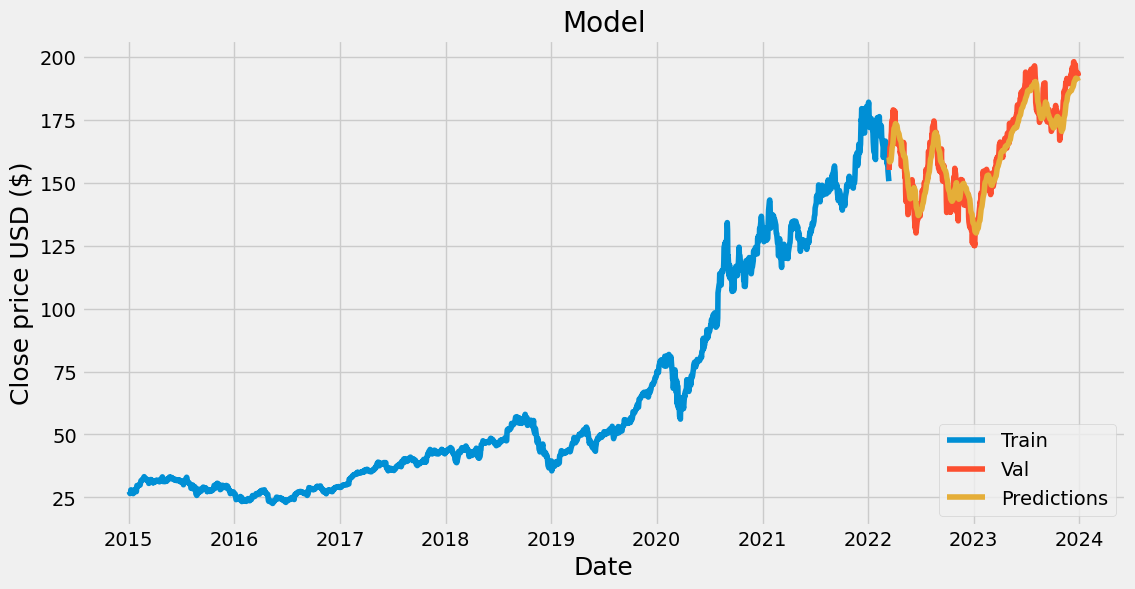

In [71]:
# plot the data
train = data[:train_size]
valid = data[train_size:]
valid['y_pred'] = y_pred

plt.figure(figsize=(12, 6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price USD ($)', fontsize=18)
plt.plot(train.loc[:, 'Close'])
plt.plot(valid.loc[:, ['Close', 'y_pred']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [72]:
# print validation data
valid

,Close,y_pred
Date,,
2022-03-15,155.089996,160.040741
2022-03-16,159.589996,158.941635
2022-03-17,160.619995,158.395142
2022-03-18,163.979996,158.286301
2022-03-21,165.380005,158.691284
...,...,...
2023-12-22,193.600006,191.524200
2023-12-26,193.050003,191.326782
2023-12-27,193.149994,191.023544


In [83]:
from types import new_class
# get quote
apple_quote = yf.download('AAPL', start='2015-01-01', end='2022-12-18')

new_df = apple_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price

[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 151ms/step


array([[143.4122]], dtype=float32)

In [86]:
apple_quote2 = yf.download('AAPL', start='2022-12-18', end='2022-12-20')
print(apple_quote2['Close'])

[*********************100%%**********************]  1 of 1 completed

Date
2022-12-19    132.369995
Name: Close, dtype: float64
